# Nutrition Datas: Extracting trends from our customers

<div class="alert alert-block alert-info">
Now we are done with scrapping nutrition values, we want to build the actual nutrition profile: in order to do so, we first need to first extract the mass of each article, in order to assess the total sold mass.
</div>

In [43]:
from __future__ import print_function

%matplotlib inline
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from requests import get
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MaxNLocator
import re
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle
import sys
sys.path.insert(1, './utilities/')
import weight_functions as wf 


In [44]:
product_df = pd.read_csv('../data/dunnhumby_data/product.csv')
transaction_data_df = pd.read_csv('../data/dunnhumby_data/transaction_data.csv')

## Limiting our dataset

In [45]:
food_related_arr = np.array(['NUTRITION','GROCERY','PASTRY','MEAT-PCKGD','SEAFOOD-PCKGD','PRODUCE','DELI','MEAT','SALAD BAR','GRO BAKERY','FROZEN GROCERY','SPIRITS','RESTAURANT'])
#products related to food only
food_product_df = product_df.loc[(product_df['DEPARTMENT'].isin(food_related_arr))]
food_product_df = food_product_df[~food_product_df.COMMODITY_DESC.isin(['PAPER TOWELS','BATH TISSUES','LAUNDRY DETERGENTS','FD WRAPS/BAGS/TRSH BG']) ]

#transaction dataset related to food only
food_transaction_data = transaction_data_df.merge(food_product_df,how = 'inner',on = 'PRODUCT_ID')

<div class="alert alert-block alert-info">
We analyze the quantity according to 2 metrics: 
    
* (1) the number of times an item is bought 
* (2) the total sold mass of the item (kg)
    
Ideally one want to have an idea of which items are consumed the most in terms of mass, unfortunately, the mass section presents a lot of different units which are not easily parsable.
</div>

In [46]:
#as we can see, there are a lot of different units
units = food_transaction_data.CURR_SIZE_OF_PRODUCT.unique()
index = np.random.choice(units.shape[0], 30, replace=False)  
units[index]

array(['158.4 OZ', '3.54 OZ', '10.66 OZ', 'CR   12 OZ', '12/8 OZ',
       '8PK/5 INCH', '10CT/22.5O', '17 OZ', '7.6 OZ.', '.812 OZ',
       '12.48 OZ', '41.6 OZ', '*    12 OZ', '27.05 OZ', '3/.25 OZ',
       '14.80 OZ', '8/2.25 OZ', '4  OZ', '5/7.4 OZ', '2LTR', '20 BAGS',
       '23OZ', 'BD 8.25 OZ', '1 GAL', '3.5 INCH', '12 OZ AERO', '1.9 OZ',
       '23.3 OZ', '3/6 OZ CAN', '4.09 OZ'], dtype=object)

In [47]:
#(1) number of bought times
food_trans_data_count = food_transaction_data[['PRODUCT_ID','QUANTITY']].copy()
food_trans_data_count = food_trans_data_count.groupby('PRODUCT_ID')\
                     .sum()\
                     .join(product_df.set_index('PRODUCT_ID')[['COMMODITY_DESC','SUB_COMMODITY_DESC','CURR_SIZE_OF_PRODUCT']],how = 'left',on = 'PRODUCT_ID',lsuffix = '_l',rsuffix = '_r')\
                     .sort_values(by = 'QUANTITY',ascending = False)

In [48]:
food_trans_data_count = food_trans_data_count.reset_index()\
                     .groupby(['COMMODITY_DESC','SUB_COMMODITY_DESC']).agg({'QUANTITY':'sum','PRODUCT_ID':'min','CURR_SIZE_OF_PRODUCT':'max'})\
                     .reset_index()\
                     .set_index('PRODUCT_ID')

<div class="alert alert-block alert-info">
The idea consists thus to take the 4000 most bought items in terms of number (~70% of all sold counts) and extract their mass exclusively, since they present a less heterogeneous dataset for the mass units.
</div>

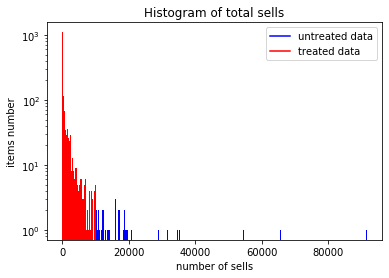

Ratio of total sells treated by treating the first 2000 samples: 0.95


In [70]:
#we restrict ourself to treat the NUM first items
NUM = 2000
N = food_trans_data_count.shape[0]
fig, ax = plt.subplots(1)
n_bins = 500
No, bins, patches = ax.hist(food_trans_data_count.QUANTITY,bins = n_bins)
ax.set_ylabel('items number')
ax.set_xlabel('number of sells')
ax.set_yscale('log')
ax.set_title('Histogram of total sells')
val = food_trans_data_count.QUANTITY.iloc[NUM]
val_bin = np.digitize(val,bins)

for i in range(0,val_bin):
    patches[i].set_facecolor('r')
for i in range(val_bin,n_bins):    
    patches[i].set_facecolor('b')
ax.plot([0,0],[0,0],'-b', label='untreated data')
ax.plot([0,0],[0,0],'-r', label='treated data')
ax.legend()
plt.show()
k = food_trans_data_count.iloc[:NUM].QUANTITY.values.sum()
t = food_trans_data_count.QUANTITY.values.sum()
ratio = k/t
print('Ratio of total sells treated by treating the first %i samples: %.2f' % (NUM,ratio) )

## Extracting the weight

In [66]:
from importlib import reload
reload(wf)

<module 'weight_functions' from './utilities/weight_functions.py'>

<div class="alert alert-block alert-info">
We now check that we indeed treat all the types of weights.
</div>

In [104]:
#check if the weight is treatable for the top4000
top4000 = food_trans_data_count.iloc[:NUM].copy()
cond = top4000[~top4000.CURR_SIZE_OF_PRODUCT.str.contains('^.*(?:LB|GA|DZ|OZ|OUNCE|PK|CT|LITER|LT|LTR|ML|QT|PT|PINT|QUART).*$|^\s?$',regex=True)].CURR_SIZE_OF_PRODUCT.unique()
print('List of weights not treated by the regex: {}'.format(cond))

List of weights not treated by the regex: ['1 BOX' '5 INCHES' 'TALL' 'LARGE' '60 GM' '7 INCH' '9 IN' '6 USE'
 '90 LOAD' '80 USE' 'BIN' '400SQ FT' '8.87 INCH' 'HD 20FT' 'SM' 'MED'
 'REGULAR' '6 PC']


In [105]:
def check (unit):
    return top4000[top4000.CURR_SIZE_OF_PRODUCT.str.contains(unit)].shape[0]
sum([check(unit) for unit in cond])

22

In [ ]:
# fuck the shit
top4000[top4000.]

<div class="alert alert-block alert-info">
The followings are the units we encounter in the top 4000:
</div>

LB = pounds<br>
GA = gallons<br>
DZ = dozens (eggs)<br>
OZ,OUNCE = ounces<br>
PK = pack (0.33 liters)<br>
CT = counts ==> USER INPUT<br>
LITER LT = liters<br>
ML = milliliters<br>
QT = quantity ==> USER INPUT<br>
PT = pint (0.473176473 liters)<br>

### Weight finding


<div class="alert alert-block alert-info">
Once again, regexes were used (cf weight_functions.py) in order to parse the weight and convert it in kg. All the liquids were assumed to have water-like density. You can test the tool in the following cell.
</div>

In [262]:
UNITS = ['LB','GA','DZ','OZ','OUNCE','PK','CT','LITER','LT','ML','QT','PT']

test_weights_volumes = ['422 Lt','(600) 4OUNCE','5.323 OZ','there is 3 pint','2 CT']
def f(x):
    tested = test_weights_volumes[x]
    print('Tested expression: %s .Equivalent weight computed: %.2f kg' % (tested,wf.get_weight(tested)))
interact(f, x=widgets.IntSlider(min=0, max=len(test_weights_volumes) - 1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [263]:
top4000['SINGLE_WEIGHT']  = top4000.CURR_SIZE_OF_PRODUCT.apply(wf.get_weight).values

<div class="alert alert-block alert-info">
The same method is used to extract the weight of the articles.
Unfortunately, the data whose metric is either CT,QT (quantity) or simply not present cannot easily be computed as this would require items specific weights. (a capsicon does not have the same weight as a pumpkin) 

We thus ask the user to estimate the weight of each item, thanks to the function start_create_single_weights.
</div>

In [264]:
ct_count = top4000[top4000.CURR_SIZE_OF_PRODUCT.str.contains('QT')].shape[0]
qt_count = top4000[top4000.CURR_SIZE_OF_PRODUCT.str.contains('QT')].shape[0]
space_count = top4000[top4000.CURR_SIZE_OF_PRODUCT == ' '].shape[0]
print('Number of non treated items: %i on %i items' % ((ct_count + qt_count + space_count),top4000.shape[0]))

Number of non treated items: 380 on 4000 items


In [265]:
top4000[top4000.SINGLE_WEIGHT.isna()].sample(4)

,QUANTITY,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,SINGLE_WEIGHT
PRODUCT_ID,,,,,
1039682,401,VEGETABLES SALAD,VARIETY LETTUCE,24 CT,NaN
863447,1261,BEEF,CHOICE BEEF,,NaN
1117393,406,SALAD BAR,SALAD BAR FRESH FRUIT,,NaN
994799,173,CITRUS,ORANGES NAVELS ALL,,NaN


In [266]:
single_weights_ct_df = pd.DataFrame.from_dict(wf.start_create_single_weights('CT',top4000),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})
single_weights_qt_df = pd.DataFrame.from_dict(wf.start_create_single_weights('QT',top4000),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})
single_weights_space_df = pd.DataFrame.from_dict(wf.start_create_single_weights('space',top4000),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})

Successful read.
Successful read.
Successful read.


In [267]:
top4000 = top4000.join(single_weights_ct_df,how = 'outer',rsuffix ='_r')
top4000.SINGLE_WEIGHT.fillna(top4000.SINGLE_WEIGHT_r,inplace = True)
top4000.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

top4000 = top4000.join(single_weights_qt_df,how = 'outer',rsuffix ='_r')
top4000.SINGLE_WEIGHT.fillna(top4000.SINGLE_WEIGHT_r,inplace = True)
top4000.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

top4000 = top4000.join(single_weights_space_df,how = 'outer',rsuffix ='_r')
top4000.SINGLE_WEIGHT.fillna(top4000.SINGLE_WEIGHT_r,inplace = True)
top4000.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

In [268]:
#we make sure that all the items now have a weight
top4000[top4000.SINGLE_WEIGHT.isna()]

,QUANTITY,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,SINGLE_WEIGHT


In [269]:
top4000['TOT_WEIGHT'] = top4000.SINGLE_WEIGHT * top4000.QUANTITY
top4000.sort_values(by = 'TOT_WEIGHT',ascending = False,inplace = True)

## Adding the nutrition

<div class="alert alert-block alert-info">
 We can now finally try to extract the desired nutrition profile.
</div>

In [270]:
top4000.sort_values(by = 'TOT_WEIGHT',ascending = False, inplace = True)

In [271]:
with open(r"../results/dunnhumb_articles_nutriments.pickle", "rb") as input_file:
    all_nutrition = pickle.load(input_file)
with open(r"../results/nutriments_units.pickle", "rb") as input_file:
    nutriment_units_df = pickle.load(input_file)
top4000 = top4000.join(all_nutrition,how = 'inner')\
                 .sort_values(by = 'TOT_WEIGHT',ascending = False)\
                 .drop(columns = ['COMMODITY_DESC','SUB_COMMODITY_DESC'])

nutriments = top4000.drop(top4000.columns[np.arange(10)],axis = 1).columns.values

In [272]:
def g(x):
    nutriment = nutriments[x]
    fig,ax = plt.subplots(1)
    #top4000[top4000.TOT_WEIGHT != 0].reset_index().head(4000).plot.bar(y = nutriment,ax = ax)
    temp = top4000[top4000.TOT_WEIGHT != 0].reset_index().head(100)
    sns.barplot(x = temp.index,y = temp[nutriment])
    unit = nutriment_units_df[nutriment_units_df['name'] == nutriment].unit_name.values[0]
    ax.set_title(nutriment)
    ax.set_ylabel('%s %s per 100 grams' % (nutriment,unit))
    ax.set_xlabel('items (sorted by most bought mass)')
    empty_string_labels = ['']*len(ax.get_xticklabels())
    ax.set_xticklabels(empty_string_labels)
interact(g, x=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=12), Output()), _dom_classes=('widget-interact',…

In [273]:
top4000.sort_values(by = 'cholesterol',ascending = False).head(100)

,QUANTITY,CURR_SIZE_OF_PRODUCT,SINGLE_WEIGHT,TOT_WEIGHT,dunn_name,dunn_ingredients,nut_name,nut_ingredients,cholesterol,energy,...,fiber,protein,sodium,sugars,total lipid,vitamin a,vitamin b-12,vitamin b-6,vitamin e,vitamin k
861272,1245,6 CT,0.300000,373.500000,EGGS EGGS - LARGE,"[egg, larg]","Egg, Benedict","[egg, benedict]",243.0,287.0,...,0.6,12.65,489.0,0.97,22.55,206.0,0.51,0.186,0.0,3.5
840361,6060,1 DZ,0.600000,3636.000000,EGGS EGGS - LARGE,"[egg, larg]","Egg, Benedict","[egg, benedict]",243.0,287.0,...,0.6,12.65,489.0,0.97,22.55,206.0,0.51,0.186,0.0,3.5
923746,5669,18 CT,0.300000,1700.700000,EGGS EGGS - LARGE,"[egg, larg]","Egg, Benedict","[egg, benedict]",243.0,287.0,...,0.6,12.65,489.0,0.97,22.55,206.0,0.51,0.186,0.0,3.5
994928,4859,1 DZ,0.600000,2915.400000,EGGS EGGS - MEDIUM,"[egg, medium]","Egg, Benedict","[egg, benedict]",243.0,287.0,...,0.6,12.65,489.0,0.97,22.55,206.0,0.51,0.186,0.0,3.5
981760,11229,1 DZ,0.600000,6737.400000,EGGS EGGS - X-LARGE,"[egg, larg]","Egg, Benedict","[egg, benedict]",243.0,287.0,...,0.6,12.65,489.0,0.97,22.55,206.0,0.51,0.186,0.0,3.5
907014,3210,8 1/2 OZ,0.056699,182.003790,BAKING MIXES MUFFIN & CORN BREAD MIX,"[bake, mix, muffin, corn, bread]","Lobster with bread stuffing, baked","[lobster, bread, stuf, bake]",119.0,175.0,...,0.6,14.85,659.0,1.23,8.20,59.0,1.00,0.096,0.0,0.7
1071939,3921,L 8 OZ,0.226796,889.267116,CHEESE CREAM CHEESE,"[chees, cream]","Cheese, cream","[chees, cream]",101.0,350.0,...,0.0,6.15,314.0,3.76,34.44,308.0,0.22,0.056,0.0,2.1
993638,1066,,0.300000,319.800000,CHICKEN/POULTRY CHIX:FRD 8PC/CUT UP (HOT),"[chicken, poultri, chix, frd, hot]","Frankfurter or hot dog, chicken","[frankfurt, hot, dog, chicken]",101.0,228.0,...,0.0,16.50,1038.0,3.17,16.16,0.0,0.49,0.275,0.0,0.0
914190,4093,L 8OZ,0.226796,928.276028,CHEESE CREAM CHEESE,"[chees, cream]","Cheese, cream","[chees, cream]",101.0,350.0,...,0.0,6.15,314.0,3.76,34.44,308.0,0.22,0.056,0.0,2.1
861445,1167,,0.300000,350.100000,CHICKEN/POULTRY CHIX: VALUE ADDED (HOT),"[chicken, poultri, chix, valu, hot]","Frankfurter or hot dog, chicken","[frankfurt, hot, dog, chicken]",101.0,228.0,...,0.0,16.50,1038.0,3.17,16.16,0.0,0.49,0.275,0.0,0.0
